<center>Заметка 3.б Практическое Фурье преобразование</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.09</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

<font color='red'>Здесь мы увидим зачем нам нужны преобразования, сдвиги, как это все можно применить в задачах. </font>

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import cmath as cm

<h3>Определение поворота</h3>

<font color='red'>В прошлый раз мы решали задачу смещения с массивами. Давайте посмотрим на эту задачу иначе. У нас есть изображение Лены и повернутое изображение Лены. Для начала создадим маску в форме круга.</font>

Для удобства и более идеального численного ответа создадим круглую маску.

In [4]:
lena = cv.imread( "/Users/maxvelichko26/Desktop/машинное зрение/extra_i2opencv_geo/zan__3/data/lena512color.tiff")
lena = cv.cvtColor( lena, cv.COLOR_BGR2GRAY)
lena = np.float64( lena )
lena.shape, lena.dtype

((512, 512), dtype('float64'))

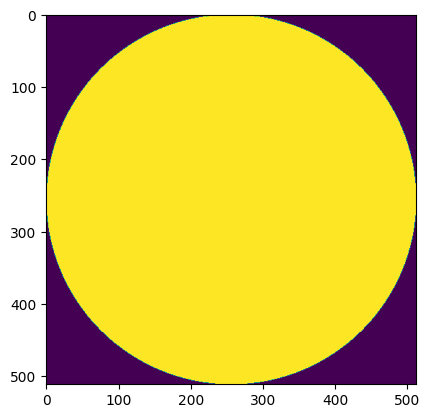

In [5]:
msk = np.zeros_like( lena )
cv.circle( msk, (256,256), 256, 1, -1)
plt.imshow( msk );

In [6]:
msk.shape, lena.shape

((512, 512), (512, 512))

In [7]:
lena[(msk > 0)].shape

(205859,)

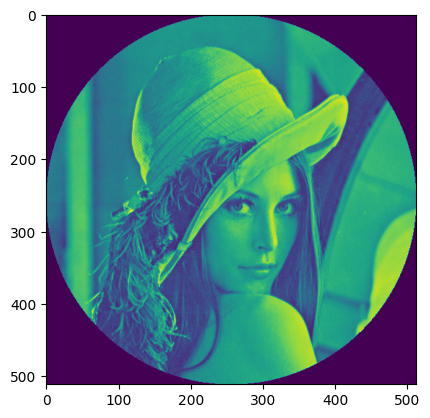

In [8]:
lena[ ~(msk > 0) ] = 0
plt.imshow( lena );

<font color='red'>Получили идеальный круг, внутри которого находится Лена. В реальной жизни идеальных изображений скорее всего вы не встретите.</font>

Поворот библиотечной функцией

<font color='red'>Делаем поворот. Дома можно попробовать поворот на разные углы.</font>

In [9]:
M = cv.getRotationMatrix2D( (256,256), 360-153, 1) # 130
M

array([[-8.91006524e-01, -4.53990500e-01,  6.00319238e+02],
       [ 4.53990500e-01, -8.91006524e-01,  3.67876102e+02]])

In [10]:
lenaQ = cv.warpAffine(lena, M, lena.shape )

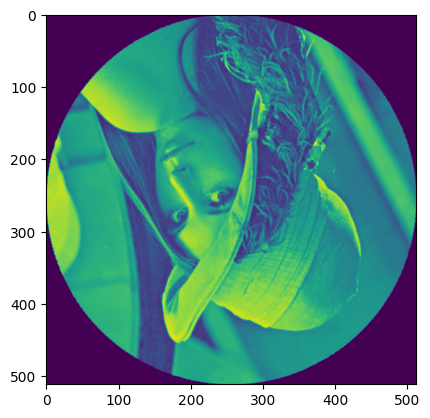

In [11]:
plt.imshow( lenaQ );

<font color='red'>Вот так выглядит повернутое изображение Лены в круге. Задача максимально прикладная: найти угол поворота одного изображения относительно другого. Наивный алгоритм говорит о том, что нужно найти все возможные повороты и сравнивать, пока не найдем полное совпадение с наименьшей ошибкой отклонения. Это неэффективно. Действовать нужно так: </font>

<b>Восстановим поворот</b>

Переведем изображения в полярный вид.

<font color='red'>Полярное преобразование - переводим в каждую точку в полярные координаты и строим новое изображение, где одна ось - угол, а другая - расстояние. </font>

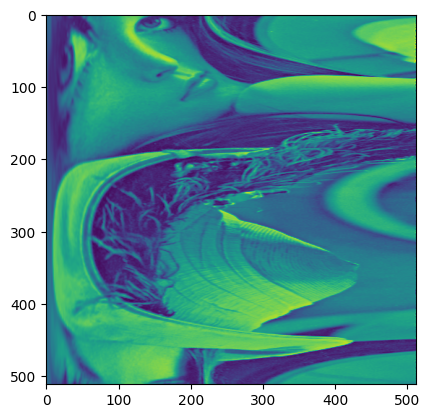

In [12]:
lenaPol = cv.linearPolar( lena, (256,256), 256, cv.INTER_CUBIC )
plt.imshow( lenaPol );

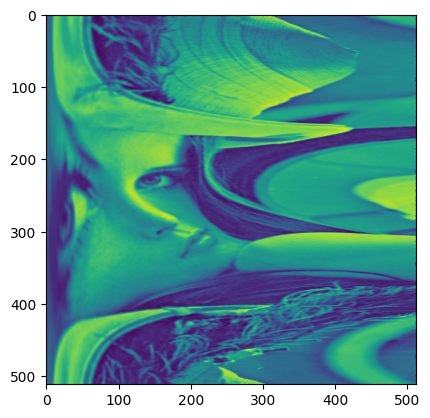

In [13]:
lenaQPol = cv.linearPolar( lenaQ, (256,256), 256, cv.INTER_CUBIC )
plt.imshow( lenaQPol );

<font color='red'>Поскольку одно изображение является лишь поворотом другого, то в полярной преобразованных изображениях мы видим сдвиг (в данном случае - вертикальный). </font>

In [14]:
lenaQPol.shape

(512, 512)

Видно, что изображения отличаются сдвигом.
Найдем величину этого сдвига и, как следствие, восстановим угол вращения.

Возьмем Фурье преобразование этих изображений.

<font color='red'>Выполняем фурье преобразование и делаем небольшой анализ результатов, сравним магнитуды полярно трансформированных изображений, они должны быть одинаковы или очень близки (в центральной точке, ближе к хвостам, краям могут быть расхождения)</font>

In [15]:
lenaPolF = np.fft.fft2( lenaPol )
lenaQPolF = np.fft.fft2( lenaQPol )

In [16]:
lenaPolFM = np.abs( lenaPolF )
lenaQPolFM = np.abs( lenaQPolF )

Посмотрим, что у них в центральной области.

In [17]:
lenaPolFM[100:105,300:3005]

array([[  633.50041521,   354.61881467,   303.37917793, ...,
        18483.12543324, 25495.55036947,  5154.1771428 ],
       [  208.62163959,   460.94553276,   363.7779445 , ...,
        27067.21072497, 18281.81966195, 22792.24514611],
       [  187.45621936,   311.24030114,   540.6733379 , ...,
        26992.23576599, 12414.55252541,  8231.65999432],
       [  251.58120487,   679.15856803,   418.25020024, ...,
        17088.3280756 ,  6844.71581541, 18943.30861011],
       [  838.3305767 ,  1372.23940709,  1569.24440459, ...,
        26763.4742417 , 17853.54988392, 15481.83982154]])

In [18]:
lenaQPolFM[100:105,300:3005]

array([[  965.7311766 ,  1140.60955578,  1044.23244638, ...,
        18489.02367502, 25137.14823952,  4237.57367781],
       [  111.89636954,   739.32182629,   494.19195002, ...,
        25426.97591374, 18024.92881277, 21018.95848092],
       [  254.47584434,   219.51967063,   143.84044261, ...,
        27003.13285612, 11459.18187084, 10142.37044667],
       [  425.94972906,   480.24830988,   406.04601913, ...,
        18741.06460025,  7614.3004718 , 18121.00289017],
       [  629.64775211,   676.99043422,   756.95631056, ...,
        26286.74679323, 18820.4302448 , 14114.73845403]])

<font color='red'>Корреляция есть, но они различаются. Сказывается в том числе и машинное эпсилон</font>

In [19]:
lenaPolFM[:5,:5]

array([[32716182.16932904,   665049.27289434,   381451.23328495,
          392517.85921926,   815646.36664894],
       [ 2903021.2390848 ,  1658469.6795058 ,  2203930.8280245 ,
         1464585.58397713,  1362266.70983149],
       [ 1223948.07779317,  2090509.11842198,   318160.65947581,
          188628.7787318 ,   136717.35135335],
       [ 1661732.63651522,   934767.20018863,   590114.31579103,
          346671.26996668,   817000.07964668],
       [  517247.1980023 ,  1017339.61264949,   266124.25858406,
          112381.76959849,   121204.07539813]])

In [20]:
lenaQPolFM[:5,:5]

array([[32706617.69176582,   656956.98605262,   384703.1797183 ,
          402437.96119148,   827024.42960379],
       [ 2900618.92982897,  1658643.92596684,  2204347.07441122,
         1460509.54429484,  1359311.15276619],
       [ 1227874.83840689,  2088337.89560159,   318978.519496  ,
          189683.73261092,   133991.51473632],
       [ 1660848.16739065,   932179.57538674,   591970.66960643,
          346085.36643264,   816157.81615215],
       [  518738.64596489,  1019756.80324353,   266325.34475738,
          112029.36707064,   118471.34222163]])

Видно, что значения похожи.

<font color='red'>Прежде чем искать углы таким образом, надо проверить, что магнитуды совпадают, если они не совпадают, то мы не можем утверждать, что это один и тот же объект. Только после этого мы можем искать угол сдвига.Мы стараемся брать энергии (магнитуды), которые не являются шумовыми, берем главные, тяжеловесные. Их отношения будут более менее совпадать. </font>

In [21]:
np.max( lenaPolFM )

32716182.169329036

Прорядим Фурье изображения для упрощения вывода.

In [22]:
sub4 = lenaPolFM[::8,::8]
sub4Q = lenaQPolFM[::8,::8]

In [23]:
sub4 /= np.max( sub4 )
sub4Q /= np.max( sub4Q )

In [24]:
np.min( sub4 )

4.399427366900554e-07

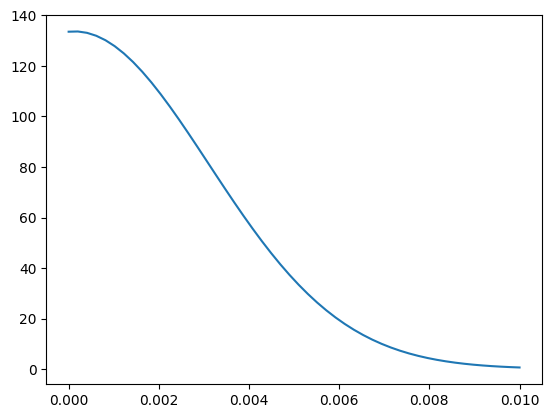

In [25]:
sm = stats.gaussian_kde( sub4.flatten() )
val = np.linspace(0., 0.01, 50)
plt.plot( val, sm( val ) );

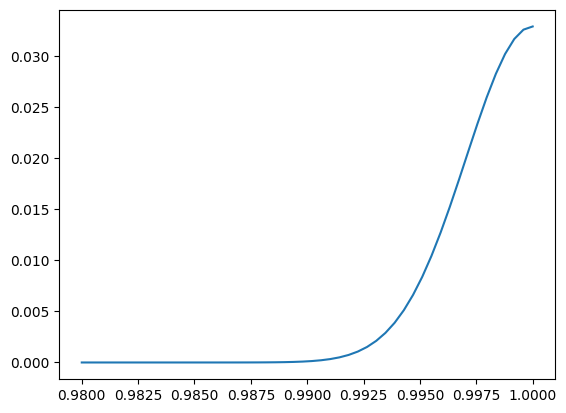

In [26]:
sm = stats.gaussian_kde( sub4.flatten() )
val = np.linspace(0.98, 1., 50)
plt.plot( val, sm( val ) );

Используем порог для вывода наиболее значимых коэффициентов.

In [27]:
sub4[ sub4>0.01 ]

array([1.        , 0.01673097, 0.01673097, 0.01330265, 0.01247905,
       0.01247905, 0.01330265])

In [28]:
sub4Q[ sub4Q>0.01 ]

array([1.        , 0.01669265, 0.01669265, 0.01324909, 0.01243919,
       0.01243919, 0.01324909])

<font color='red'>На прореженных изображениях магнитуды практически идеально совпадают, плюс прореженные изображения требуют значительно меньший объем вычислений</font>

Видно, что кэффициенты магнитуды совпадают.
Значит будет корректным определить угол поворота через фазу.

In [29]:
lenaQPolF_ = lenaQPolF[::8,::8]
lenaPolF_ = lenaPolF[::8,::8]

In [30]:
az = lenaQPolF_[ sub4Q>0.01 ]/lenaPolF_[ sub4Q>0.01 ]
az

array([ 0.99970765+0.j        ,  0.99726334+0.01755386j,
        0.99726334-0.01755386j, -0.80791101-0.58194763j,
        0.30469726+0.94878911j,  0.30469726-0.94878911j,
       -0.80791101+0.58194763j])

In [31]:
np.angle( az )*256*np.pi

array([    0.        ,    14.15492748,   -14.15492748, -2024.58462008,
        1013.39767287, -1013.39767287,  2024.58462008])

В итоге будем действоать по найшей формуле.

In [32]:
lenaPolF[0,1], lenaPolF[1,0]

((662825.0319909407+54346.22658013187j),
 (2270429.037118945+1809056.1909417193j))

In [33]:
lenaQPolF[0,1], lenaQPolF[1,0]

((654739.2008253152+53935.706410183935j),
 (-1200532.1258179238-2640513.7361811367j))

<font color='red'>Получим угол через отношение повернутого изображения к оригинальному, умножив на количество пикселей в длину изображения</font>

In [34]:
ang = np.angle(lenaQPolF[1,0]/lenaPolF[1,0])*512/(2*np.pi)
ang
# Вычислиле количество пикселей в полярной системе координат.

-217.59548734694255

In [35]:
(ang/512)*2*180
# Угол поворота. 153. Совпадает с тем что было.

-152.99682704081897

<font color='red'>Получили угол в 153 градуса, как и было нами указано при повороте изначально. Можно поиграться с разными вариантами угла и посмотреть.</font>

<h2>Рябь</h2>

<font color='red'>Преобразование Фурье позволяет избавиться от ряби на изображении или других шумов. Загрузим изображение и применим преобразование фурье. </font>

In [36]:
lena = cv.imread( "./data/lena512color.tiff")[:,:,::-1]
lena = cv.cvtColor( lena, cv.COLOR_RGB2GRAY)
lena.shape, lena.dtype

((512, 512), dtype('uint8'))

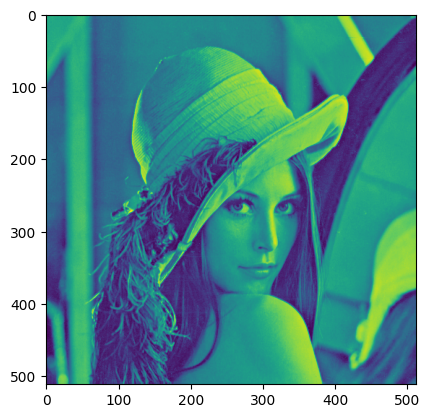

In [37]:
plt.imshow( lena );

In [38]:
flena = np.fft.fft2( lena )

Влияние изменения фурье области на изображение.

<font color='red'> Взяли случайную точку и присвоили ей новое значение энергии </font>

In [43]:
flena[15, 20] = 10000000.

In [44]:
lena2 = np.abs( np.fft.ifft2( flena ) )
lena2.shape, lena2.dtype

((512, 512), dtype('float64'))

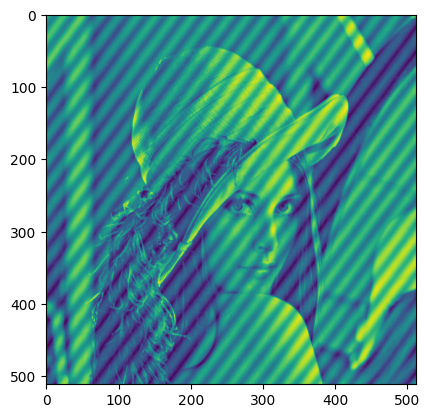

In [45]:
plt.imshow( lena2 );

<font color='red'>Это привело к появлению ряби на изображении. Исходя из этого мы можем действовать наоборот, убирать рябь с изображения</font>

Видим, что изображение покрылось рябью.

<b>Устранение ряби</b>

Теперь в обратную сторону. Восстановим изображение от ряби.

<font color='red'>Возьмем новое изображение, добавим рябь с помошью синуса. Такая рябь может иметь место в реальной жизни</font>

In [46]:
rlena = lena.copy()

In [47]:
xsin = np.sin( np.linspace(0, 20*np.pi, 512) )
xsin.shape

(512,)

In [48]:
rlena = rlena + 50*xsin

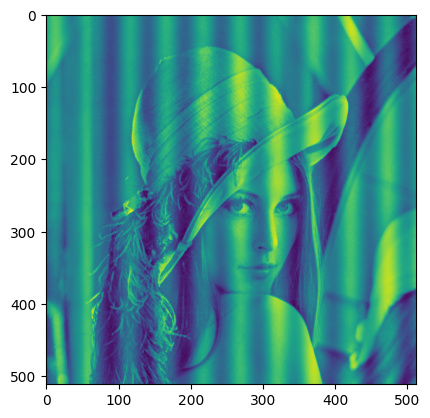

In [49]:
plt.imshow( rlena );

Сравним Фурье преобразования.

In [50]:
flena = np.fft.fft2( lena )
frlena = np.fft.fft2( rlena )

In [51]:
fshift = np.fft.fftshift( flena )
mag = 20*np.log( np.abs( fshift ) )

<font color='red'>Строим изображение преобразования</font>

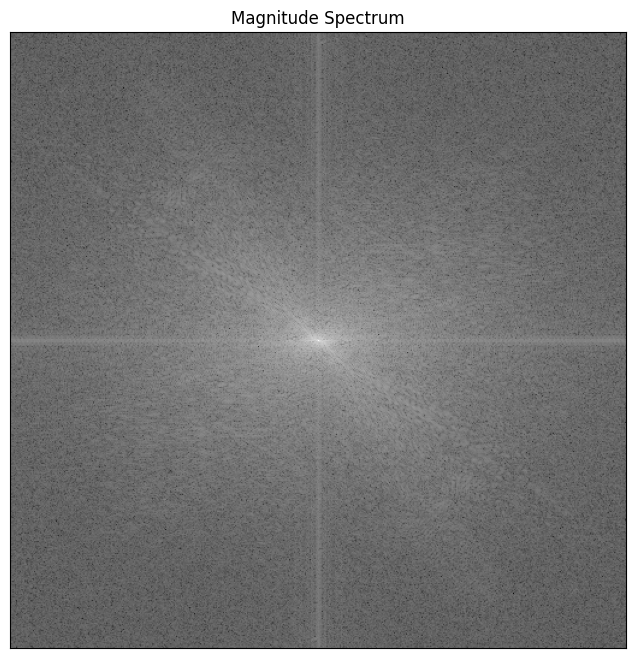

In [52]:
plt.figure( figsize = (8,8) )
plt.imshow( mag, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

Теперь для изображения с рябью.

In [53]:
frshift = np.fft.fftshift( frlena )
rmag = 20 * np.log( np.abs( frshift ) )

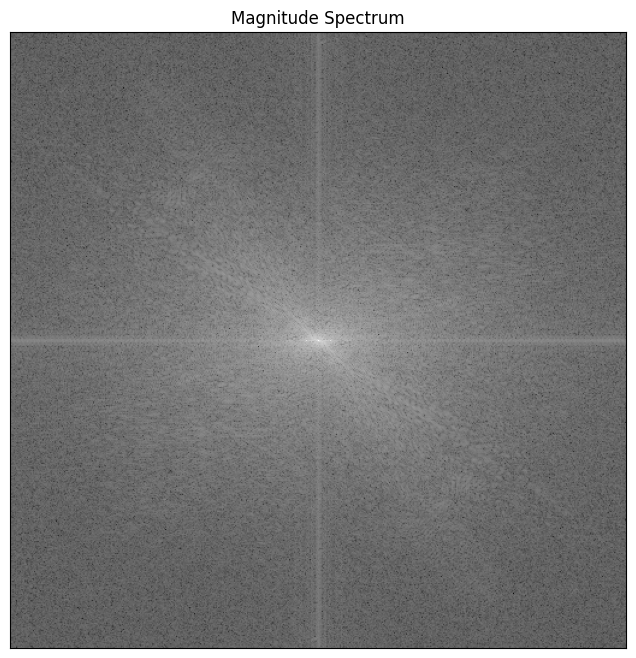

In [54]:
plt.figure( figsize = (8,8) )
plt.imshow( rmag, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

<font color='red'>Как мы упоминали ранее, основная энергия находится в центре</font>

Сразу и не увидешь разницу.

Укрупним центр.

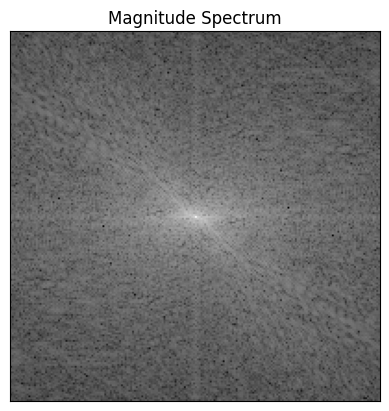

In [55]:
plt.imshow( mag[ 256 - 100 : 256 + 100, 256 - 100 : 256 + 100 ], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

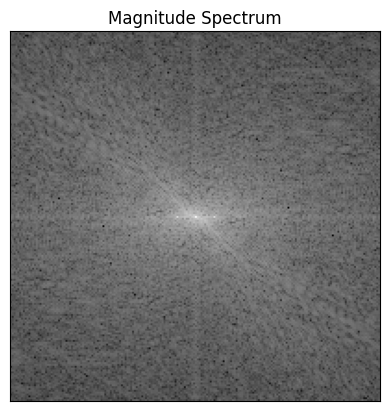

In [56]:
plt.imshow( rmag[ 256 - 100 : 256 + 100, 256 - 100 : 256 + 100 ], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

Уже что виднеется, а именно -- на последнем изображении видны пара точек.

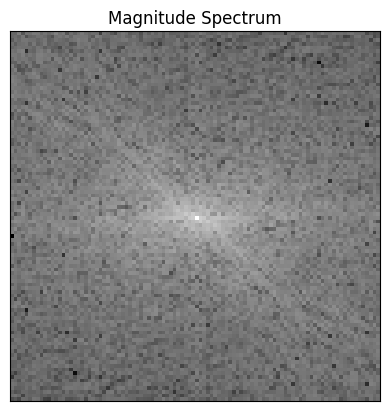

In [57]:
plt.imshow( mag[ 256 - 50 : 256 + 50, 256 - 50 : 256 + 50 ], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

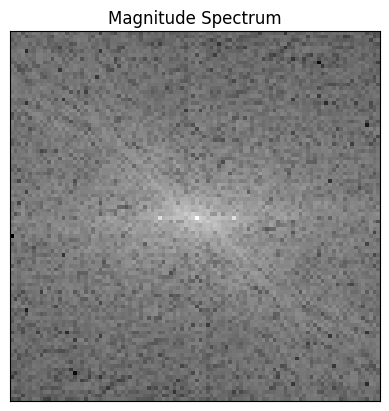

In [58]:
plt.imshow( rmag[ 256 - 50 : 256 + 50, 256 - 50 : 256 + 50 ], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

Теперь они видны боле отчетвливо.
Приблизимся ещё ближе.

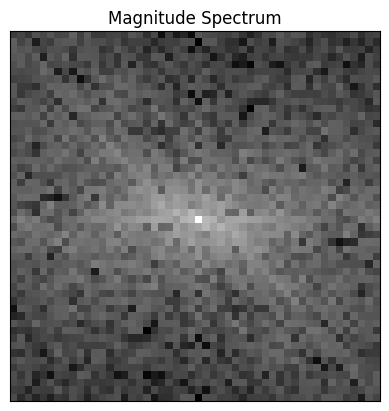

In [59]:
plt.imshow( mag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

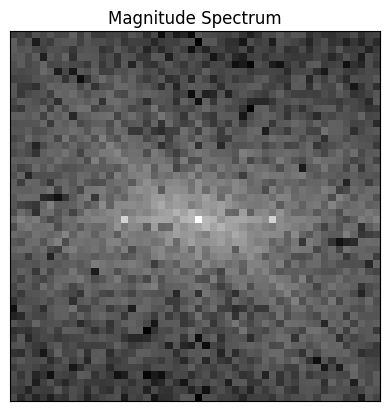

In [60]:
plt.imshow( rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

<font color='red'>В центре - основная энергия изображения. А точки по бокам от нее - это то, что мы хотим убрать</font>

Теперь их видно четко.
Найдем их.

<font color='red'>Нашли максимальное значение изображения</font>

In [61]:
np.max( rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ] )

345.94644721527504

<font color='red'>Далее берем пороговое значение 300 (энергия чуть меньше максимума), пробуем выделить только эти три точки</font>

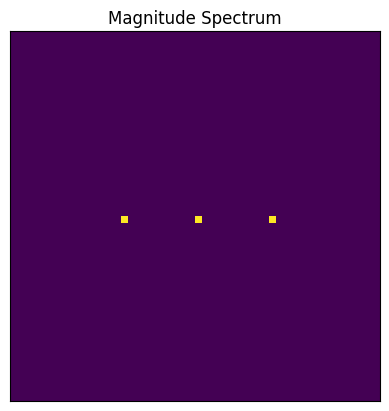

In [62]:
plt.imshow( rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ] > 300 )
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

<font color='red'>Остались только 3 самых мощных точки. При этом центральная энергия достаточно выше боковых. Боковые с точки зрения матанализа можно назвать "соразрывными". Это странные точки - вылеты, нехарактерные для нормального изображения, это должна быть причина шума. </font>

In [63]:
rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ][ rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ] > 300 ]

array([313.02073217, 345.94644722, 313.02073217])

In [64]:
np.sum( rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ] > 300 )

3

<font color='red'>Найдем координаты этих точек</font>

In [65]:
np.where( rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ] > 300 )

(array([25, 25, 25]), array([15, 25, 35]))

Занулим найденные точки.

In [66]:
frshift[ 256 - 25 + 25, 256 - 25 + 15 ] = 0
frshift[ 256 - 25 + 25, 256 - 25 + 35 ] = 0

In [67]:
rmag = 20 * np.log( np.abs( frshift ) + 1) # +1 чтобы не было деления на 0

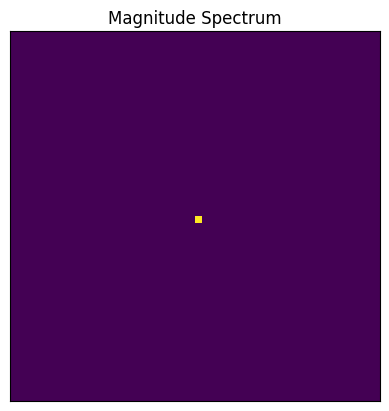

In [68]:
plt.imshow( rmag[ 256 - 25 : 256 + 25, 256 - 25 : 256 + 25 ] > 300 )
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]);

Занулили правильные точки.

Выполним обратное преобразование.

In [69]:
fflena = np.fft.ifftshift( frshift )

In [70]:
lena2 = np.abs( np.fft.ifft2( fflena ) )
lena2.shape, lena2.dtype

((512, 512), dtype('float64'))

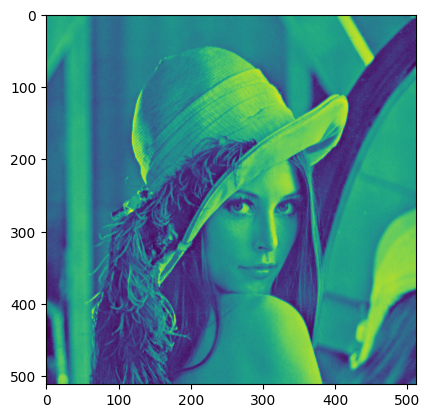

In [71]:
plt.imshow( lena2 );

<font color='red'>Восстановили изображение без ряби</font>

Полосы явно пропали.

Найдем все же отличие между изображениями.

<font color='red'>Разница между исходным изображением  и очищенным изображением с синусовым шумом.</font>

In [72]:
dlena = np.abs(np.abs(lena2-lena))
np.max( dlena )

7.0165440976952596

In [73]:
7/255

0.027450980392156862

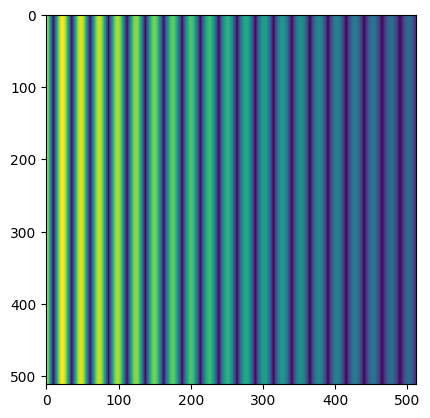

In [74]:
plt.imshow( dlena );

<font color='red'>Какая-то рябь все равно осталась</font>

Что будет, если не занулить, а выставить иное некоторое значение?

<font color='red'>Желательно присваивать значения, близкие к значениям окружающих точек, а также такие, чтобы после фурье преобразования все комплексные числа имели близкие к нулю части, надо подобрать константу, чтобы было хорошо. </font>

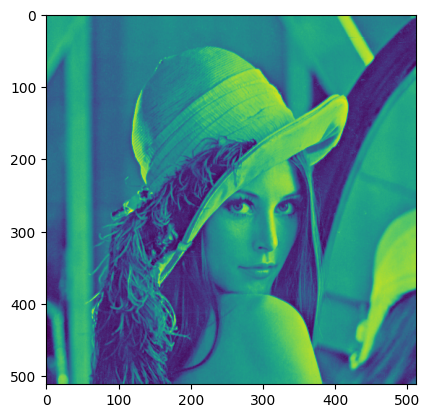

In [75]:
frshift[ 256 - 25 + 25, 256 - 25 + 15 ] = 500000
frshift[ 256 - 25 + 25, 256 - 25 + 35 ] = 500000
fflena = np.fft.ifftshift( frshift )
lena2 = np.abs( np.fft.ifft2( fflena ) )
plt.imshow( lena2 );

In [76]:
dlena = np.abs(np.abs(lena2-lena))
np.max( dlena )

3.804227645077674

Ошибка уменьшилась.

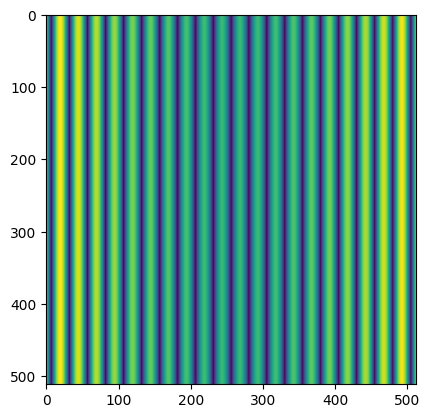

In [77]:
plt.imshow( dlena );

<font color='red'>Видна явная связь представления этой энергии изображения и ошибки. Стоит поиграться, постараться подобрать такие константы, чтобы ошибка и остаточных шум был минимальным. </font>

<font color='red'>При восстановлении высоких частот на замыленном изображении за счет фурье преобразования, изображение становится более резким. </font>

<font color='red'>Далее ответы на вопросы, но сами вопросы не слышно на видео: </font>

<font color='red'>У нас есть изображение, с которого мы хотим убрать шум. Мы делаем сперва фурье преобразование и убираем все компоненты, которые носят какой-то регулярный характер или принимают максимальные значения. Мы их зануляем и делаем обратное преобразование.</font>

Доп ссылки:

https://docs.opencv.org/master/d1/dfd/tutorial_motion_deblur_filter.html

https://docs.opencv.org/4.0.0-alpha/d1/dfd/tutorial_motion_deblur_filter.html

https://docs.opencv.org/4.0.0-alpha/de/d3c/tutorial_out_of_focus_deblur_filter.html